# GPT2-xl installation



Import GPT2-xl with the available RAM on colab

In [ ]:
!pip install transformers
!pip install accelerate
!pip install concept-erasure
!pip install datasets

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import sklearn
from tqdm import tqdm
from functools import reduce
import scipy
import itertools
import seaborn as sns
from concept_erasure import leace
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from google.colab import drive
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import huggingface_hub
from transformers import AutoTokenizer, AutoModelForCausalLM

cosim = torch.nn.CosineSimilarity(-1)
drive.mount('/content/drive')

In [ ]:
#when debugging, use gpt2 to be faster
debugging = False
torch.set_grad_enabled(False)

if debugging:
  tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
  model = GPT2LMHeadModel.from_pretrained('gpt2')
else:
  tokenizer = GPT2TokenizerFast.from_pretrained('gpt2-xl')
  model = GPT2LMHeadModel.from_pretrained('gpt2-xl', device_map="auto", offload_folder="offload", offload_state_dict=True)

model.eval()

In [ ]:
device = torch.device('cuda')
model.to(device)
tokenizer.pad_token = tokenizer(" \xa0")

# Learning Hyperplane Leace + Probe

Quantile formula: $\text{quantile} = Q_{\frac{1+\mathbb{E}[Z]}{2}}(d_{\text{plane}} \cdot X)\frac{d_{\text{plane}}}{||d_{\text{plane}}||_2^2}$

In [ ]:
#Implement a better version, using means of median ?
def get_quantile(leace_eraser, target_activations):
  #We compute the parameters of the hyperplane to project against.
  hyperplane = (leace_eraser.proj_right[0]/torch.norm(leace_eraser.proj_right[0], dim = -1).unsqueeze(-1)).squeeze().to(device)

  #We sort the projection.
  sorted_tensor, indices = torch.sort(torch.einsum('nd, ...d -> n...', target_activations, hyperplane), dim = -1)
  del indices

  Nb_ex = len(target_activations)
  #See above for the quantile formula.
  quantile = (sorted_tensor[Nb_ex//2 + 1] + sorted_tensor[(Nb_ex-1)//2+1])*(hyperplane)/2

  del sorted_tensor
  del hyperplane

  return quantile

In [ ]:
def storing_hyperplanes(dataset : list[list], post_layer_norm = True):
  #To save the RAM, we need to compute by batch
  N_sub_data = len(dataset)

  #First, we measure the length of each prompt to be able to find the right
  #indices on which to measure the probability.
  tokenized_data = [[tokenizer(data[0])["input_ids"] for data in sub_dataset] for sub_dataset in dataset]
  indices = [torch.Tensor([len(tokens)-1 for tokens in tokenized_sub_data]).to(int).to(device) for tokenized_sub_data in tokenized_data]

  #Now we tokenize for real, to compute the whole sub_dataset at the same time.
  tokenized_data = [tokenizer([word[0] for word in sub_dataset], padding = True, return_tensors = 'pt')["input_ids"].to(device) for sub_dataset in dataset]
  positions = [torch.Tensor([i for i in range(tokenized_sub_data.shape[1])]).to(int).to(device) for tokenized_sub_data in tokenized_data]

  #We initialise our tensors for each dataset
  activations = [model.transformer.wte(tokenized_sub_data) + model.transformer.wpe(position) for tokenized_sub_data, position in zip(tokenized_data, positions)]
  labels = [torch.Tensor([[prompt[1]] for prompt in sub_dataset]).unsqueeze(-1) for sub_dataset in dataset]

  del tokenized_data

  dim_label = labels[0][0].shape[1]
  dim_residual = activations[0][0].shape[-1]

  eraser_mean = []
  eraser_quantile = []
  eraser_probe = []

  for layer in tqdm(range(len(model.transformer.h))):
    #Initiating the leace estimator, default parameters.
    leace_fitter = leace.LeaceFitter(dim_residual, dim_label)

    target_activations = []
    for i in range(N_sub_data):

      #We update each activation through the next layer.
      if layer != 0:
        activations[i] = model.transformer.h[layer](activations[i],)[0] #**{'position_ids':positions[i]}

      #We choose the activation of the targeted tokens and fit the leace estimator.
      if post_layer_norm:
        acts = model.transformer.h[layer].ln_1(activations[i])
      else:
        acts = activations[i]

      target_activations.append(torch.cat([act[ind].unsqueeze(0) for act, ind in zip(acts, indices[i])], dim = 0).to(device))
      leace_fitter.update(target_activations[i], labels[i])
      del acts

    all_target_act = torch.cat(target_activations, dim = 0)
    all_labels = torch.cat(labels, dim = 0).squeeze()

    #We only keep the eraser. The rest is not useful anymore.
    eraser = leace_fitter.eraser

    #We compute the quantile to have the equal-leace estimator.
    quantile = get_quantile(eraser, all_target_act).unsqueeze(0)

    eraser_mean.append(leace.LeaceEraser(
        proj_right = eraser.proj_right.to(device),
        proj_left = eraser.proj_left.to(device),
        bias = eraser.bias.to(device),
    ))
    eraser_quantile.append(leace.LeaceEraser(
        proj_right = eraser.proj_right.to(device),
        proj_left = eraser.proj_left.to(device),
        bias = quantile.to(device),
    ))

    #We learn the best probe, we need at least 1500 steps to converge
    if post_layer_norm:
      probe = LogisticRegression(random_state=0, max_iter=2000).fit(
              all_target_act.to('cpu'),
              all_labels.to('cpu')
              )

      eraser_probe.append(leace.LeaceEraser(
          proj_right = torch.Tensor(probe.coef_).to(device),
          proj_left = ((torch.Tensor(probe.coef_)/(torch.norm(torch.Tensor(probe.coef_), dim = -1)**2).unsqueeze(-1)).T).to(device),
          bias = -probe.intercept_[0]*(torch.Tensor(probe.coef_)/(torch.norm(torch.Tensor(probe.coef_), dim = -1).unsqueeze(-1)**2)).to(device),
      ))

  #Deletion of all the useless tensor to avoid RAM overload.

      del probe
    del leace_fitter
    del eraser
    del target_activations
    del all_target_act
    del all_labels
  del activations
  del indices
  del labels
  del positions

  return eraser_mean, eraser_quantile, eraser_probe

In [ ]:
#Learn the estimators
eraser_mean_1, eraser_quantile_1, eraser_probe_1 = storing_hyperplanes(Data_1, post_layer_norm = True)
eraser_mean_1_res, eraser_quantile_1_res, eraser_probe_1_res = storing_hyperplanes(Data_1, post_layer_norm = False)
#eraser_mean_2, eraser_quantile_2, eraser_probe_2 = storing_hyperplanes(Train_2, post_layer_norm = True)

100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


# Hyperplane Probes Eval

In [ ]:
def leace_eval(eraser_list):
  def metric(target_activations, layer : int, true_label):
    dir = eraser_list[layer].proj_right[0].to(device)
    bias = eraser_list[layer].bias.to(device)
    Nb_ex = len(target_activations)

    #we compute the accuracy
    acc = torch.sum(cosim(dir, target_activations - bias)*true_label > 0).item()/Nb_ex

    del dir
    del bias

    return acc
  return metric

In [ ]:
def hyperplane_acc(examples : list[str], eval_metric : list):

  indices_list = []
  activations = []
  positions = []
  for example in examples:

    tokenized_data = [tokenizer(data[0])["input_ids"] for data in example]
    indices_list.append(torch.Tensor([len(tokens)-1 for tokens in tokenized_data]).to(int))

    tokenized_data = tokenizer([word[0] for word in example], padding = True, return_tensors = 'pt')["input_ids"].to(device)

    positions.append(torch.arange(tokenized_data.shape[1]).to(int).to(device))
    activations.append(model.transformer.wte(tokenized_data) + model.transformer.wpe(positions[-1]))

  all_labels = torch.cat(
      [torch.Tensor([word[1] for word in example]).unsqueeze(-1) for example in examples]
      , dim = 0
  ).squeeze().to(device)

  del tokenized_data

  acc_list = []
  for layer in tqdm(range(len(model.transformer.h))):

    target_activations = []
    for b in range(len(activations)):

      if layer != 0:
        activations[b] = model.transformer.h[layer](activations[b],)[0] #**{'position_ids': positions[b]}

      target_activations.append(torch.cat([act[ind].unsqueeze(0) for act, ind in zip(model.transformer.h[layer].ln_1(activations[b]), indices_list[b])], dim = 0).to(device))

    all_target_act = torch.cat(target_activations, dim = 0).to(device)

    acc = []
    for metric in eval_metric:
      acc.append(metric(all_target_act, layer, all_labels))
    acc_list.append(acc)

  del activations
  del indices_list

  return [[acc[i] for acc in acc_list] for i in range(len(acc_list[0]))]

In [ ]:
metric_q = leace_eval(eraser_quantile_1)
metric_m = leace_eval(eraser_mean_1)
metric_p = leace_eval(eraser_probe_1)

acc_data = hyperplane_acc(Data_1, [metric_q, metric_m, metric_p])

acc_data_q = acc_data[0]
acc_data_m = acc_data[1]
acc_data_p = acc_data[2]

100%|██████████| 48/48 [00:59<00:00,  1.23s/it]


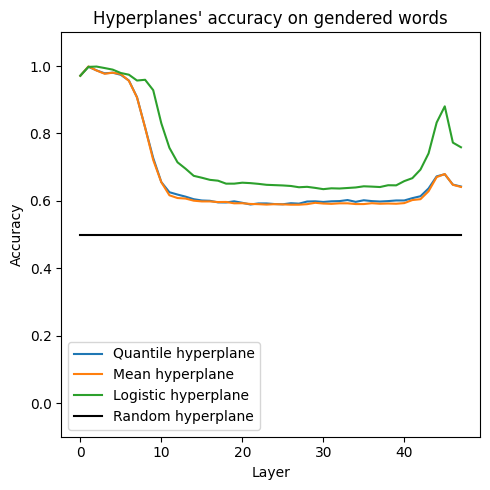

In [ ]:
nb_layers = len(model.transformer.h)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex = True, sharey = True)

axes.plot(acc_data_q, label = 'Quantile hyperplane')
axes.plot(acc_data_m, label = 'Mean hyperplane')
axes.plot(acc_data_p, label = 'Logistic hyperplane')
axes.plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random hyperplane')
axes.set_title("Hyperplanes' accuracy on gendered words")
axes.set_xlabel("Layer")
axes.set_ylabel("Accuracy")
axes.set_ylim(-0.1, 1.1)
axes.legend()

plt.tight_layout()
plt.show()

In [ ]:
metric_q = leace_eval(eraser_quantile_2)
metric_m = leace_eval(eraser_mean_2)
metric_p = leace_eval(eraser_probe_2)

acc_data = hyperplane_acc(Data_2, [metric_q, metric_m, metric_p])

acc_data_q = acc_data[0]
acc_data_m = acc_data[1]
acc_data_p = acc_data[2]

100%|██████████| 48/48 [00:14<00:00,  3.27it/s]


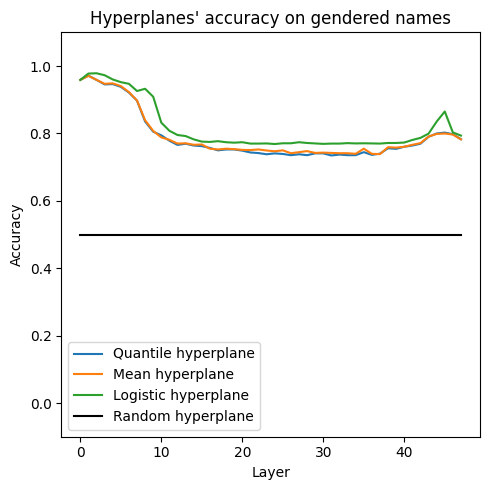

In [ ]:
nb_layers = len(model.transformer.h)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex = True, sharey = True)

axes.plot(acc_data_q, label = 'Quantile hyperplane')
axes.plot(acc_data_m, label = 'Mean hyperplane')
axes.plot(acc_data_p, label = 'Logistic hyperplane')
axes.plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random hyperplane')
axes.set_title("Hyperplanes' accuracy on gendered names")
axes.set_xlabel("Layer")
axes.set_ylabel("Accuracy")
axes.set_ylim(-0.1, 1.1)
axes.legend()

plt.tight_layout()
plt.show()

# Learning Direction Probe

In [ ]:
def storing_directions(meta_dataset : list[list], post_layer_norm = True):
  #To save the RAM, we need to compute by batch
  N_sub_data = len(meta_dataset[0])

  indices = []
  activations = []
  positions = []
  for dataset in meta_dataset:

    #First, we measure the length of each prompt to be able to find the right
    #indices on which to measure the probability.
    tokenized_data = [[tokenizer(data[0], return_tensors = 'pt')["input_ids"].to(device) for data in sub_dataset] for sub_dataset in dataset]
    indices.append([torch.Tensor([len(tokens[0])-1 for tokens in tokenized_sub_data]).to(int).to(device) for tokenized_sub_data in tokenized_data])

    #Now we tokenize for real, to compute the whole sub_dataset at the same time.
    tokenized_data = [tokenizer([word[0] for word in sub_dataset], padding = True, return_tensors = 'pt')["input_ids"].to(device) for sub_dataset in dataset]
    positions.append([torch.Tensor([i for i in range(tokenized_sub_data.shape[1])]).to(int).to(device) for tokenized_sub_data in tokenized_data])

    #We initialise our tensors for each dataset
    activations.append([model.transformer.wte(tokenized_sub_data) + model.transformer.wpe(position) for tokenized_sub_data, position in zip(tokenized_data, positions[-1])])

  del tokenized_data

  dim_label = 1
  dim_residual = activations[0][0][0].shape[-1]

  eraser_mean = []
  eraser_probe = []

  for layer in tqdm(range(len(model.transformer.h))):
    #Initiating the leace estimator, default parameters.
    leace_fitter = leace.LeaceFitter(dim_residual, dim_label)

    target_activations = []
    for b in range(len(activations)):

      super_target_activations = []
      for i in range(N_sub_data):

        #We update each activation through the next layer.
        if layer != 0:
          activations[b][i] = model.transformer.h[layer](activations[b][i],)[0] #**{'position_ids': positions[b][i]}

        #We choose the activation of the targeted tokens and fit the leace estimator.
        if post_layer_norm:
          super_target_activations.append(torch.cat([act[ind].unsqueeze(0) for act, ind in zip(model.transformer.h[layer].ln_1(activations[b][i]), indices[b][i])], dim = 0).to(device))
        else:
          target_activations.append(torch.cat([act[ind].unsqueeze(0) for act, ind in zip(activations[i], indices[i])], dim = 0).to(device))

      target_activations.append(super_target_activations)

    target_activations = [sub_target_act - sup_target_act for sub_target_act, sup_target_act in zip(target_activations[0], target_activations[1])]
    all_target_act = torch.cat(target_activations, dim = 0)
    all_labels = torch.zeros(all_target_act.shape[0]) + 1

    #We only keep the eraser. The rest is not useful anymore.
    leace_fitter.update(all_target_act, all_labels)
    leace_fitter.update(-all_target_act, -all_labels)
    eraser = leace_fitter.eraser

    eraser_mean.append(leace.LeaceEraser(
        proj_right = eraser.proj_right.to(device),
        proj_left = eraser.proj_left.to(device),
        bias = eraser.bias.to(device),
    ))

    #We learn the best probe, we need at least 1500 steps to converge
    probe = LogisticRegression(random_state=0, max_iter=2000).fit(
            torch.cat([all_target_act, -all_target_act], dim = 0).to('cpu'),
            torch.cat([all_labels, -all_labels], dim = 0).to('cpu')
            )

    eraser_probe.append(leace.LeaceEraser(
        proj_right = torch.Tensor(probe.coef_).to(device),
        proj_left = (eraser.proj_left/(torch.norm(eraser.proj_left, dim = 0).unsqueeze(0)*torch.norm(torch.Tensor(probe.coef_), dim = -1).unsqueeze(-1))).to(device),
        bias = -probe.intercept_[0]*(torch.Tensor(probe.coef_)/(torch.norm(torch.Tensor(probe.coef_), dim = -1).unsqueeze(-1)**2)).to(device),
    ))


    del leace_fitter
    del eraser
    del target_activations
    del all_target_act
    del all_labels
    del probe

  del activations
  del indices
  del positions

  return eraser_mean, eraser_probe

In [ ]:
eraser_dir_mean_1, eraser_dir_probe_1 = storing_directions([[Data_m_1], [Data_f_1]], post_layer_norm = True)

100%|██████████| 48/48 [01:40<00:00,  2.09s/it]


# Direction Probe Eval

In [ ]:
def direction_acc(meta_examples : list[list[str]], eval_metric: list):

  indices_list = []
  activations = []
  positions = []
  for examples in meta_examples:

    tokenized_data = [tokenizer(data)["input_ids"] for data in examples]
    indices_list.append(torch.Tensor([len(tokens)-1 for tokens in tokenized_data]).to(int))

    tokenized_data = tokenizer(examples, padding = True, return_tensors = 'pt')["input_ids"].to(device)

    positions.append(torch.arange(tokenized_data.shape[1]).to(int).to(device))
    activations.append(model.transformer.wte(tokenized_data) + model.transformer.wpe(positions[-1]))

  del tokenized_data

  acc_list = []
  for layer in tqdm(range(len(model.transformer.h))):

    target_activations = []
    for b in range(len(activations)):

      if layer != 0:
        activations[b] = model.transformer.h[layer](activations[b],)[0] #**{'position_ids': positions[b]}

      target_activations.append(torch.cat([act[ind].unsqueeze(0) for act, ind in zip(model.transformer.h[layer].ln_1(activations[b]), indices_list[b])], dim = 0).to(device))

    all_target_act = target_activations[0] - target_activations[1]

    acc = []
    for metric in eval_metric:
      acc.append(metric(all_target_act, layer, 1))
    acc_list.append(acc)

  del activations
  del indices_list
  del positions

  return [[acc[i] for acc in acc_list] for i in range(len(acc_list[0]))]

In [ ]:
metric_m = leace_eval(eraser_dir_mean_1)
metric_p = leace_eval(eraser_dir_probe_1)

acc_data = direction_acc([[word[0] for word in Data_m_1], [word[0] for word in Data_f_1]], [metric_m, metric_p])

acc_data_m = acc_data[0]
acc_data_p = acc_data[1]

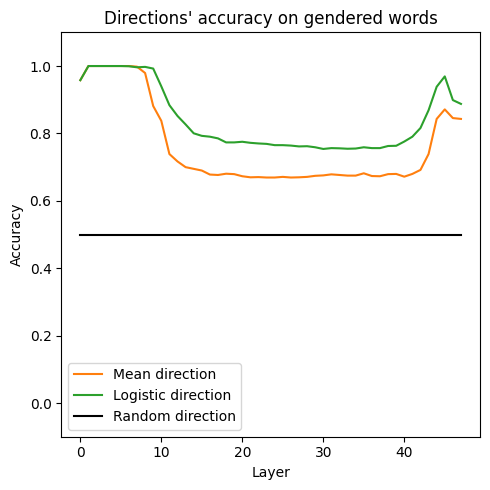

In [ ]:
nb_layers = len(model.transformer.h)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex = True, sharey = True)

axes.plot(acc_data_m, label = 'Mean direction', color = 'C1')
axes.plot(acc_data_p, label = 'Logistic direction', color = 'C2')
axes.plot([0, nb_layers-1],[0.5, 0.5], color = 'black', label = 'Random direction')
axes.set_title("Directions' accuracy on gendered words")
axes.set_xlabel("Layer")
axes.set_ylabel("Accuracy")
axes.set_ylim(-0.1, 1.1)
axes.legend()

plt.tight_layout()
plt.show()

#Testing sets

In [ ]:
def token_augmentation(list, text_list):
  for text in text_list:
    for i in range(1, len(text)):
      if (text[:i] != " ") and (text[i:] != " "):
        list.append(tokenizer(text[:i])["input_ids"] + tokenizer(text[i:])["input_ids"])

In [ ]:
#list of tokens counted as "good" answers
text_lists = [["he", " he", "He", " He",
                 "him", " him", "Him", " Him",
                 "his", " his", "His", " His",
                 "male", " male", "Male", " Male",
                 "son", " son", "Son", " Son",
                 "father", " father", "Father", " Father",
                 "boy", " boy", "Boy", " Boy",
                 ],
              ["she", " she", "She", " She",
               "her", " her", "Her", " Her",
               "female", " female", "Female", " Female",
               "daugther", " daugther", "Daugther", " Daugther",
               "mother", " mother", "Mother", " Mother",
               "girl", " girl", "girl", " girl",]]
token_lists = [tokenizer(text_list).input_ids for text_list in text_lists]
#token_augmentation(token_lists_A[0], text_lists_A[0])
#token_augmentation(token_lists_A[1], text_lists_A[1])

In [ ]:
#female sentences

#evaluation prompt
example_prompts_A = ["The young lady is talented and is a musician. Answer:",
       "The actress is skilled and performed flawlessly. Answer:",
       "The daughter is intelligent and loves to read. Answer:",
       "The bride is stunning and chose a beautiful gown. Answer:",
       "The princess is kind-hearted and helps others. Answer:",
       "The girl is diligent and scored top grades. Answer:",
       "The mother is caring and always puts family first. Answer:",
       "The princess is determined and trains tirelessly. Answer:",
       "Their mother is creative and invents unique recipes. Answer:",
       "The grandmother is wise and shares valuable stories. Answer:",
       "The lady is fashionable and has a great sense of style. Answer:",
       "The queen is powerful and rules with authority. Answer:",
       "The aunt is nurturing and takes care of the children. Answer:",
       "The heroine is brave and faces danger without fear. Answer:",
       "The woman is confident and speaks loud. Answer:",
       "The female CEO is successful and leads the company to prosperity. Answer:",
       "The girl is imaginative and creates fantastic stories. Answer:",
       ]


#use "" to ask for the last token
target_text_A = [
    " lady",
    " actress",
    " daughter",
    " bride",
    " princess",
    " girl",
    " mother",
    " princess",
    " mother",
    " grandmother",
    " lady",
    " queen",
    " aunt",
    " heroine",
    " woman",
    " female",
    " girl",
]
target_tokens_A = tokenizer(target_text_A).input_ids

pre_prompt_a = "He is a boy. Answer: male \n "
pre_prompt_b = "She is a girl. Answer female \n "

pre_prompt = "The task is to predict the gender of the character in the following sentences. Answer only using the word 'female' or 'male'. \n "

example_prompts_A = [tokenizer.eos_token
                     + pre_prompt
                     + pre_prompt_b
                     + pre_prompt_a
                     + example for example in example_prompts_A] + [tokenizer.eos_token
                     + pre_prompt
                     + pre_prompt_a
                     + pre_prompt_b
                     + example for example in example_prompts_A]

target_tokens_A += target_tokens_A

In [ ]:
#male sentences

#evaluation prompt
example_prompts_B = ["The young lord is talented. Answer:",
       "The actor is skilled. Answer:",
       "The son is intelligent. Answer:",
       "The prince is kind-hearted. Answer:",
       "The boy is diligent. Answer:",
       "The father is caring. Answer:",
       "The prince is determined. Answer:",
       "Their father is creative. Answer:",
       "The grandfather is wise. Answer:",
       "The king is powerful. Answer:",
       "The hero is brave and has no fear. Answer:",
       "The man is confident and speaks loud. Answer:",
       "The male CEO is successful and leads the company to prosperity. Answer:",
       "The father-in-law is supportive and offers guidance. Answer:",
       "The boy is imaginative and creates fantastic stories. Answer:",
       ]


#use "" to ask for the last token
target_text_B = [
    " lord",
    " actor",
    " son",
    " prince",
    " boy",
    " father",
    " prince",
    " father",
    " grandfather",
    " king",
    " hero",
    " man",
    " male",
    " father-in-law",
    " boy",
]
target_tokens_B = tokenizer(target_text_B).input_ids

pre_prompt_a = "He is a boy. Answer: male \n "
pre_prompt_b = "She is a girl. Answer female \n "

pre_prompt = "The task is to predict the gender of the caracter in the following sentences. Answer only using the word 'female' or 'male'.\n"

example_prompts_B = [tokenizer.eos_token
                     + pre_prompt
                     + pre_prompt_b
                     + pre_prompt_a
                     + example for example in example_prompts_B] + [tokenizer.eos_token
                     + pre_prompt
                     + pre_prompt_a
                     + pre_prompt_b
                     + example for example in example_prompts_B]

target_text_B += target_text_B

In [ ]:
#female names

#evaluation prompt: checked that all prompt are understood by GPT2-xl
example_prompts_C = ["Hi, my name is " + name + ". Answer:" for name in Test_f]

#use "" to ask for the last token
target_text_C = [" " + name for name in Test_f]
target_tokens_C = tokenizer(target_text_C).input_ids

pre_prompt_a = "He is a boy. Answer: male \n "
pre_prompt_b = "She is a girl. Answer female \n "

pre_prompt = "The task is to predict the gender of the caracter in the following sentences. Answer only using the word 'female' or 'male'.\n"

example_prompts_C = [tokenizer.eos_token
                     + pre_prompt
                     + pre_prompt_b
                     + pre_prompt_a
                     + example for example in example_prompts_C] + [tokenizer.eos_token
                     + pre_prompt
                     + pre_prompt_a
                     + pre_prompt_b
                     + example for example in example_prompts_C]

target_tokens_C += target_tokens_C

In [ ]:
#male names
#!! doesn't recognize correctly all of them !!

#evaluation prompt: checked that all prompt are understood by GPT2-xl
example_prompts_D = ["Hi, my name is " + name[0] + ". Answer:" for name in Test_m_2]

#use "" to ask for the last token
target_text_D = [" " + name[0] for name in Test_m_2]
target_tokens_D = tokenizer(target_text_C).input_ids

pre_prompt_a = "He is a boy. Answer: male \n "
pre_prompt_b = "She is a girl. Answer female \n "

pre_prompt = "The task is to predict the gender of the caracter in the following sentences. Answer only using the word 'female' or 'male'.\n"

example_prompts_D = [tokenizer.eos_token
                     + pre_prompt
                     + pre_prompt_b
                     + pre_prompt_a
                     + example for example in example_prompts_D] + [tokenizer.eos_token
                     + pre_prompt
                     + pre_prompt_a
                     + pre_prompt_b
                     + example for example in example_prompts_D]

# Verifying Testing sets


In [ ]:
def show_proba(proba, level = 0.01, nb_tokens = 10, decode = False):
  #From a probability, get the top-{nb_tokens} tokens that have more than {level} probability.

  if decode:
    #to print the words
    proba_token_list = [(proba[i].item(), tokenizer.decode([i])) for i in range(len(proba)) if proba[i] > level]
  else:
    #to print the tokens
    proba_token_list = [(proba[i].item(), i) for i in range(len(proba)) if proba[i] > level]

  proba_token_list.sort()
  return proba_token_list[-nb_tokens:]

In [ ]:
#code to easily implement the visualasation
prompts = example_prompts_C

tokenized_sentences = [tokenizer(prompt, return_tensors = 'pt')["input_ids"].to(device) for prompt in prompts]

for tokenized_sentence, prompt in zip(tokenized_sentences, prompts):
  print(prompt)
  #print(show_proba(torch.softmax(model(tokenized_sentence).logits[0, -1], dim = -1), nb_tokens = 5, decode = True))

<|endoftext|>The task is to predict the gender of the caracter in the following sentences. Answer only using the word 'female' or 'male'.
She is a girl. Answer female 
 He is a boy. Answer: male 
 Hi, my name is Estella. Answer:
<|endoftext|>The task is to predict the gender of the caracter in the following sentences. Answer only using the word 'female' or 'male'.
She is a girl. Answer female 
 He is a boy. Answer: male 
 Hi, my name is Susan. Answer:
<|endoftext|>The task is to predict the gender of the caracter in the following sentences. Answer only using the word 'female' or 'male'.
She is a girl. Answer female 
 He is a boy. Answer: male 
 Hi, my name is Lenna. Answer:
<|endoftext|>The task is to predict the gender of the caracter in the following sentences. Answer only using the word 'female' or 'male'.
She is a girl. Answer female 
 He is a boy. Answer: male 
 Hi, my name is Mina. Answer:
<|endoftext|>The task is to predict the gender of the caracter in the following sentences. 

# Leace erasure

In [ ]:
#Fast way to compute the probability for any nb_tokens but only when the tokens are of length one.
def fast_proba(token_list, len_example, proba):
  arr = torch.arange(len(len_example))
  proba = torch.sum(proba[arr, len_example][:, token_list].squeeze(-1), dim = -1).unsqueeze(0)
  del arr
  return proba


#Computes rapidly the probability with all the hooks.
def fast_forward(tokens, hook, leace_list, layers):
  for layer in layers:
    model.transformer.h[layer].register_forward_pre_hook(hook(leace_list[layer]))#.attn

  logits = model(tokens.to(device)).logits

  for layer in layers:
    model.transformer.h[layer]._forward_pre_hooks.clear()#.attn

  return torch.softmax(logits, dim = -1)


#Compute the probability of male and female tokens when applying the hook at all the relevant layers.
def fast_compute_score(tokens, token_lists, leace_list, len_example, hook, layer_list):
  score = []
  for layers in layer_list:
    probas = fast_forward(tokens, hook, leace_list, layers)

    proba_male = fast_proba(token_lists[0], len_example, probas)
    proba_female = fast_proba(token_lists[1], len_example, probas)

    score.append(torch.cat([proba_male, proba_female], dim = 0).unsqueeze(0))

    del proba_male
    del proba_female
    del probas

  return score


#Fast way to intervene on the cache by using the custom attention.
def fast_cache_intervention(stream_indices, example_indices, stream_example_indices, meta_hook):
  def aux(tokens, token_lists, leace_list, leace_res_list, len_example, hook, layer_list, layer_res_list):
    score = []
    for layers, layers_res in zip(layer_list, layer_res_list):

      for layer in layers:
        model.transformer.h[layer].attn.register_forward_hook(meta_hook(hook(leace_list[layer])))

      for layer in layers_res:
        model.transformer.h[layer].attn.register_forward_pre_hook(hook(leace_res_list[layer]))

      logits = model(tokens.to(device)).logits

      for layer in layers:
        model.transformer.h[layer].attn._forward_hooks.clear()

      for layer in layers_res:
        model.transformer.h[layer].attn._forward_pre_hooks.clear()

      probas = torch.softmax(logits, dim = -1)

      proba_male = fast_proba(token_lists[0], len_example, probas)
      proba_female = fast_proba(token_lists[1], len_example, probas)

      score.append(torch.cat([proba_male, proba_female], dim = 0).unsqueeze(0))

      del proba_male
      del proba_female
      del probas

    return score
  return aux


#Initiate a fast way to compute the score, that doesn't involves looking at tokens of length > 1.
def fast_score(example_prompts, token_lists, leace_list, leace_res_list, target_tokens,
               layer_list, layer_res_list, lbds = [1], attention_only = False):

  #We measure the length of each example to know where the answer is.
  example_tokens = [tokenizer(example_prompt).input_ids for example_prompt in example_prompts]
  len_examples = torch.Tensor([len(tokens)-1 for tokens in example_tokens]).to(int)

  #We create a list of all the position where to do the hook.
  #We only hook the last example of the target_tokens.
  stream_indices, example_indices, stream_example_indices = finds_indices(example_tokens, target_tokens)

  #We tokenize all example together, with padding, to be faster.
  example_tokens = tokenizer(example_prompts, padding = True, return_tensors = 'pt').input_ids.to(device)


  if attention_only:
    fast_method = fast_cache_intervention(stream_indices, example_indices, stream_example_indices,
                                          hook_attn(stream_indices, example_indices, stream_example_indices))
  else:
    fast_method = fast_compute_score

  print("Computation of writing scores")
  score = []
  for lbd in tqdm(lbds):
    hook = hook_wte(lbd, stream_indices, example_indices)
    score.append(fast_method(example_tokens, token_lists, leace_list, leace_res_list, len_examples,
                                 hook, layer_list, layer_res_list))

  del example_tokens
  del stream_indices
  del example_indices
  del stream_example_indices
  del len_examples

  return score

In [ ]:
#Custom attention module. It compute sequentially the attention pattern by first
#computing the attention until the first cut (which is the first min of
#stream_example_indices[0]), then it changes ex ante the key and value of the right
#example and stream so that the targeted gendered token will be changed. It then
#continues likewise until the next targeted stream until the list is empty.
def attn_forward(module,
                 hidden_states,
                 hook,
                 stream_indices,
                 example_indices,
                 stream_example_indices):

  #We compute the usual query, key and values.
  query, key, value = module.c_attn(hidden_states).split(module.split_size, dim=2)

  query = module._split_heads(query, module.num_heads, module.head_dim)
  key = module._split_heads(key, module.num_heads, module.head_dim)
  value = module._split_heads(value, module.num_heads, module.head_dim)

  #We compute the modified key and values.
  _ , interv_key, interv_value = module.c_attn(hook(None, (hidden_states,))[0]).split(module.split_size, dim=2)

  interv_key = module._split_heads(interv_key, module.num_heads, module.head_dim)
  interv_value = module._split_heads(interv_value, module.num_heads, module.head_dim)

  last_stream = 0
  a = []

  for stream in range(hidden_states.shape[1]):
    if stream in stream_example_indices[0]:

      #list of all examples where to hook
      example_ind = stream_example_indices[1][torch.where(stream_example_indices[0] == stream)[0]]
      target_indices = torch.cat([torch.where(example_indices == ex)[0] for ex in example_ind], dim = 0)
      example_ind = example_indices[target_indices]
      stream_ind = stream_indices[target_indices]

      aux_query = query[:, :, :stream+1]
      aux_key = key[:, :, :stream+1]
      aux_value = value[:, :, :stream+1]

      #We compute the attention until {stream}.
      attn_outputs, _ = module._attn(aux_query, aux_key, aux_value)
      a.append(attn_outputs[:, :, last_stream:])

      #We change afterward the cache on the targeted examples.
      key[example_ind, :, stream_ind] = interv_key[example_ind, :, stream_ind]
      value[example_ind, :, stream_ind] = interv_value[example_ind, :, stream_ind]
      last_stream = stream+1

  attn_outputs, _ = module._attn(query, key, value)
  a.append(attn_outputs[:, :, last_stream:])

  a = torch.cat(a, dim = 2)
  a = module._merge_heads(a, module.num_heads, module.head_dim)
  a = module.c_proj(a)

  present = (key, value)

  outputs = (a, present,)
  return outputs

In [ ]:
#Finds the occurences of the target inside the examples,
#but only the last one for each target.
def finds_indices(example_tokens, target_tokens):

  #stream_indice is the list of all streams where the target was detected
  stream_indices = []
  #example_indice is the list of all example where the target was detected
  example_indices = []
  #stream_example_indices is the list that gives the last stream of each token targeted
  #as well as the example it was seen in
  stream_example_indices = [[],[]]


  for i, (example, target_token) in enumerate(zip(example_tokens, target_tokens)):
    len_target = len(target_token)

    #If there is no target, we hook the last stream.
    if len(target_token) == 0:
      s_indice = torch.Tensor([len(example)])
      e_indice = torch.Tensor([i])
      stream_example_indices[0].append(len(example))
      stream_example_indices[1].append(i)

    #Otherwise, we hook the targeted streams.
    else:
      position = torch.where(torch.Tensor(example) == target_token[0])[0][-1].item() #[-1] means that we take only the last occurence
      if [example[i] for i in range(position, position + len_target)] == target_token:

        s_indice = torch.Tensor([pos for pos in range(position, position + len_target)])
        e_indice = torch.Tensor([i]*len_target)
        stream_example_indices[0].append(position + len_target - 1)
        stream_example_indices[1].append(i)
      else:
        print("Error, no target found.")

    stream_indices.append(s_indice)
    example_indices.append(e_indice)

  return torch.cat(stream_indices, dim = 0).to(int), torch.cat(example_indices, dim = 0).to(int), torch.Tensor(stream_example_indices).to(int)

In [ ]:
#write in the direction of the difference in mean
def hook_wte(lbd, stream_indices, example_indices):
  def meta_hook(leace_eraser):
    def hook(module, input):
      input[0][example_indices, stream_indices] -= lbd*leace_eraser.proj_left.T*((input[0][example_indices, stream_indices]-leace_eraser.bias)@leace_eraser.proj_right.T)
      return input
    return hook
  return meta_hook


#Overwrite the usual attention mechanism with a custom one.
def hook_attn(stream_indices, example_indices, stream_example_indices):
  def meta_hook(hookk):
    def hook(module, input, output):
      return attn_forward(module, input[0], hookk, stream_indices, example_indices, stream_example_indices)
    return hook
  return meta_hook

In [ ]:
#We compute all of the leace fitters and erasers
nb_layers = len(model.transformer.h)
layer_list = [[i for i in range(0, 5)]]
layer_res_list = [[6]]
token_lists = [[[token[0]] for token in token_lists[0]], [[token[0]] for token in token_lists[1]]]
lbds = torch.Tensor([i/10 for i in range(0, 61, 1)])

#doesn't work well if there is mulpiple occurence of the target token
score_A = fast_score(example_prompts_A, token_lists, eraser_mean_1, eraser_mean_1_res, target_tokens_A, layer_list, layer_res_list, lbds = lbds, attention_only = True)
#score_B = fast_score(example_prompts_B, token_lists, eraser_mean_1, eraser_mean_1_res, target_tokens_B, layer_list, layer_res_list, lbds = lbds, attention_only = True)
#score = fast_score(example_prompts_C, token_lists, eraser_mean_1, target_tokens_C, layer_list, lbds = lbds, attention_only = True)
#score = fast_score(example_prompts_A, token_lists, eraser_mean_2, target_tokens_A, layer_list, lbds = lbds, attention_only = True)
#score = fast_score(example_prompts_B, token_lists, eraser_mean_2, target_tokens_B, layer_list, lbds = lbds, attention_only = True)
#score_C = fast_score(example_prompts_C, token_lists, eraser_mean_2, target_tokens_C, layer_list, lbds = lbds, attention_only = False)

Computation of writing scores


100%|██████████| 61/61 [02:05<00:00,  2.07s/it]


In [ ]:
for module in model.transformer.h:
  module._forward_pre_hooks.clear()
  module.attn._forward_pre_hooks.clear()
  module.attn._forward_hooks.clear()

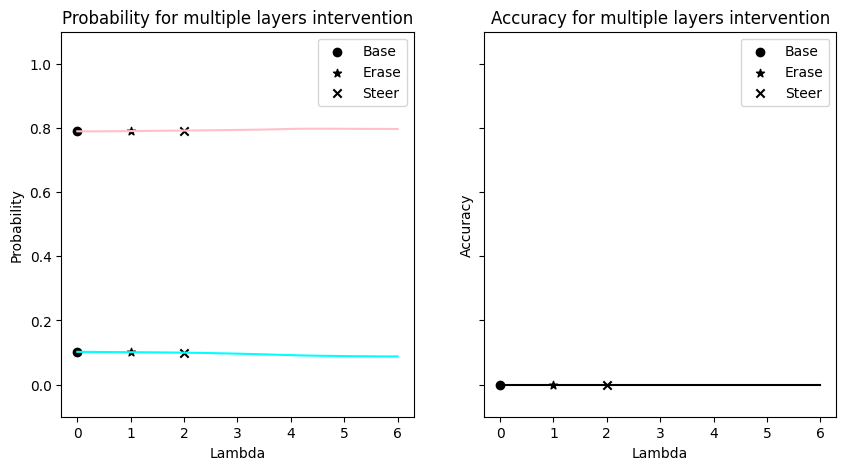

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex = True, sharey = True)
dir = 1
score = score_A

s = torch.mean(torch.cat([s[0] for s in score], dim = 0), dim = -1).T.to('cpu')
acc = [torch.mean(torch.Tensor([[1 if (score_l[1] - score_l[0])*dir > 0 else 0 for score_l in sub_score[0].T] for sub_score in scOre]), dim = -1).item() for scOre in score]

axes[0].scatter([0, 0], [s[0][0], s[1][0]], color = "k", label = 'Base')
axes[0].scatter([1, 1], [s[0][10], s[1][10]], color = 'k', label = 'Erase', marker = "*")
axes[0].scatter([2, 2], [s[0][20], s[1][20]], color = 'k', label = 'Steer', marker = "x")
axes[0].plot(lbds, s[0], color = 'cyan')
axes[0].plot(lbds, s[1], color = 'pink')

axes[0].legend()
axes[0].set_title("Probability for multiple layers intervention")
axes[0].set_xlabel("Lambda")
axes[0].set_ylabel("Probability")
axes[0].set_ylim(-0.1, 1.1)

axes[1].scatter([0], [acc[0]], color = "k", label = 'Base')
axes[1].scatter([1], [acc[10]], color = 'k', label = 'Erase', marker = "*")
axes[1].scatter([2], [acc[20]], color = 'k', label = 'Steer', marker = "x")
axes[1].plot(lbds, acc, color = 'black')
axes[1].set_xlabel("Lambda")
axes[1].set_title("Accuracy for multiple layers intervention")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

<ipython-input-28-83ad6634c273>:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  accs = [torch.mean(torch.Tensor([[1 if (score_l[1] - score_l[0])*dir > 0 else 0 for score_l in sub_score.T] for sub_score in score]), dim = -1) for score in score]
<ipython-input-28-83ad6634c273>:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


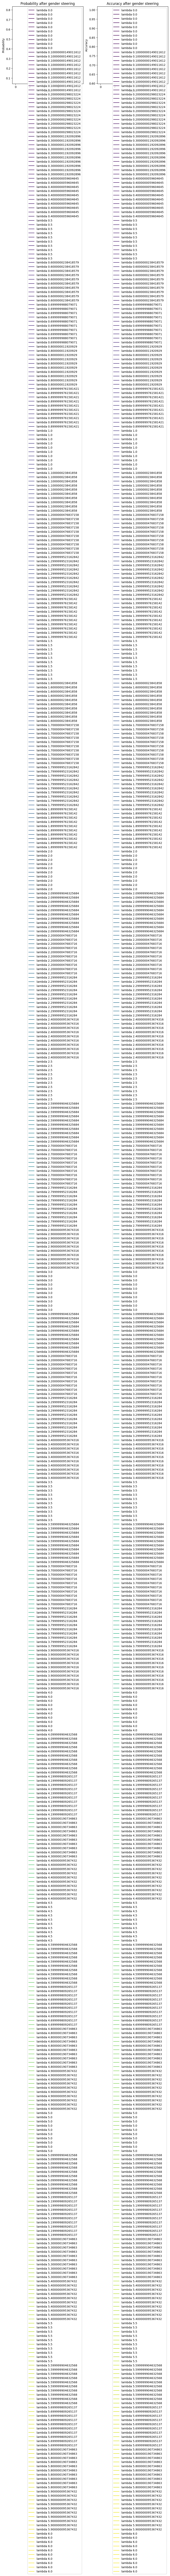

In [ ]:
nb_layers = len(model.transformer.h)
dir = 1
colormap = plt.cm.viridis
N = len(lbds)
score = score_A

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex = True)

probas = [torch.mean(torch.cat(score, dim = 0), dim = -1) for score in score]

for i, proba in enumerate(probas):
  axes[0].plot(layer_list, [g[0].item() for g in proba], label = 'lambda {}'.format(lbds[i]), color=colormap(i/N))
  axes[0].plot(layer_list, [g[1].item() for g in proba], color=colormap(i/N))
axes[0].set_title("Probability after gender steering")
axes[0].set_xlabel("Layer")
axes[0].set_ylabel("Probability")
axes[0].legend()

accs = [torch.mean(torch.Tensor([[1 if (score_l[1] - score_l[0])*dir > 0 else 0 for score_l in sub_score.T] for sub_score in score]), dim = -1) for score in score]

for i, acc in enumerate(accs):
  axes[1].plot(layer_list, acc, label = 'lambda {}'.format(lbds[i]), color=colormap(i/N))
axes[1].set_title("Accuracy after gender steering")
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

# Continuation Modification

In [ ]:
#function to make gpt2 output sentence and have a modification (writing or erasing)

def hook_spe(lbd, stream_indices, example_indices):
  def meta_hook(leace_eraser):
    def hook(module, input):
      if input[0].shape[1] != 1:
        input[0][example_indices, stream_indices] -= lbd*leace_eraser.proj_left.T*((input[0][example_indices, stream_indices]-leace_eraser.bias)@leace_eraser.proj_right.T)
      return input
    return hook
  return meta_hook

def hook_spe_attn(stream_indices, example_indices, stream_example_indices):
  def meta_hook(hookk):
    def hook(module, input, output):
      if input[0].shape[1] != 1:
        return attn_forward(module, input[0], hookk, stream_indices, example_indices, stream_example_indices)
      else:
        return output
    return hook
  return meta_hook

def generate_hook(example : str, target_text : list[str], nb_sequences : int,
                  max_len : int, hook_layer = [],
                  leace_eraser = None, lbd = 1):

  example_tokens = tokenizer(example, return_tensors = 'pt')["input_ids"].to(device)
  target_tokens = [tokenizer(text).input_ids for text in target_text]
  stream_indices, example_indices, stream_example_indices = finds_indices(example_tokens, target_tokens)

  hook_flag = []
  for layer in hook_layer:
    hook_flag.append(model.transformer.h[layer].attn.register_forward_hook(
                    hook_spe_attn(stream_indices, example_indices, stream_example_indices)(hook_spe(lbd, stream_indices, example_indices)(leace_eraser[layer]))
                    ))

  torch.manual_seed(0)
  sentences = [tokenizer.batch_decode(model.generate(example_tokens,
                                                     max_length = max_len + example_tokens.shape[-1],
                                                     do_sample = False,
                                                     num_return_sequences = 1))]

  for flag in hook_flag:
    flag.remove()

  return sentences

In [ ]:
#nice sentences
"I love my son, he is always very nice to me. Yesterday, we were alone and he told me"
"This man is so sexy, I want to ask"
"The nurse helped me get my leg attached. She was"
"My patient Lily is very nervous when she"
"My patient, she is very nervous when she"

'My patient, she is very nervous when she'

In [ ]:
sentence = "My patient, she is very nervous when she"
target_text = [' she']
hook_layer = [i for i in range(0, 48)]
nb_max_tokens = 20
lbds = [0, 1, 2]

for module in model.transformer.h:
  module.attn._forward_hooks.clear()

sentence = [generate_hook(tokenizer.eos_token + sentence,target_text, 1, nb_max_tokens,
                               hook_layer = hook_layer, leace_eraser = eraser_mean_1, lbd = lbd) for lbd in lbds]

print(f"For layer {hook_layer[0]} to {hook_layer[-1]}, \n", lbds, "\n", np.array(sentence))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


For layer 0 to 47, 
 [0, 1, 2] 
 [[['<|endoftext|>My patient, she is very nervous when she comes to see me. She is a young woman, about 25 years old, and she has been']]

 [['<|endoftext|>My patient, she is very nervous when she comes in. She is a very young woman, and she is very shy. She is very nervous']]

 [['<|endoftext|>My patient, she is very nervous when she comes to her "She is"\n\n"She is"\n\n"She is"\n']]]


In [ ]:
device = "cpu"

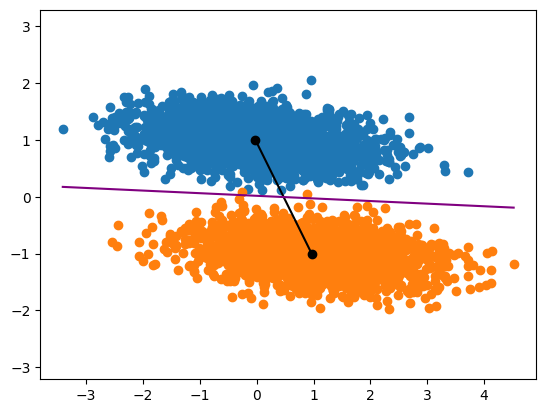

In [ ]:
mean = torch.tensor([.0, 1])
cov_matrix = torch.tensor([[1+0.1, -0.1],
                           [-0.1, 0.1]])
mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix = cov_matrix)

num_samples = 2000
nb_seen = 2000
samples_1 = torch.transpose(mvn.sample((num_samples,)), 0, 1)
label_1 = torch.Tensor([1]*num_samples)

plt.scatter(samples_1[0][:nb_seen], samples_1[1][:nb_seen])
plt.scatter(torch.mean(samples_1[0]), torch.mean(samples_1[1]), color = 'black')

mean = torch.tensor([1.0, -1])
cov_matrix = torch.tensor([[1+0.1, -0.1],
                           [-0.1, 0.1]])
mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov_matrix)

samples_2 = torch.transpose(mvn.sample((num_samples,)), 0, 1)
label_2 = torch.Tensor([-1]*num_samples)

plt.scatter(samples_2[0][:nb_seen], samples_2[1][:nb_seen])
plt.scatter(torch.mean(samples_2[0]), torch.mean(samples_2[1]), color = 'black')
plt.plot([torch.mean(samples_1[0]), torch.mean(samples_2[0])], [torch.mean(samples_1[1]), torch.mean(samples_2[1])], color = 'black', label = 'Diff in mean')

leace_estimator = leace.LeaceFitter(2, 1, method = 'leace') #, constrain_cov_trace = False, shrinkage = False)
leace_estimator.update(torch.transpose(samples_1,0,1), label_1)
leace_estimator.update(torch.transpose(samples_2,0,1), label_2)
eraser = leace_estimator.eraser

samples = torch.cat((samples_1, samples_2), dim = -1)

x_min = torch.min(samples[0])
x_max = torch.max(samples[0])
y_min = torch.min(samples[1])
y_max = torch.max(samples[1])
EX = eraser.bias
#Q = get_quantile(eraser, samples.T)

samples = torch.transpose(eraser(torch.transpose(samples, 0, 1)), 0, 1)
W_inv = torch.Tensor(scipy.linalg.sqrtm(np.array(torch.mean(torch.cat([torch.einsum('...a, ...b -> ...ab', X-EX, X-EX).unsqueeze(0) for X in torch.transpose(samples, 0, 1)], dim = 0), dim = 0))))
W = torch.Tensor(np.linalg.inv(np.array(W_inv)))
proj = (samples.T[0] - samples.T[1])

l_max = (x_max-EX[0])/proj[0]
l_min = (x_min-EX[0])/proj[0]
plt.plot([x_min, x_max],[EX[1] + l_min*proj[1], EX[1] + l_max*proj[1]], color = 'purple', label = 'Leace mean proj')

#l_max = (x_max-Q[0])/proj[0]
#l_min = (x_min-Q[0])/proj[0]
#plt.plot([x_min, x_max],[Q[1] + l_min*proj[1], Q[1] + l_max*proj[1]], color = 'red', label = 'Leace quantile proj')

proj = eraser.proj_right[0]
#l_max = (x_max-EX[0])/proj[0]
#l_min = (x_min-EX[0])/proj[0]
#plt.plot([x_min, x_max],[EX[1] + l_min*proj[1], EX[1] + l_max*proj[1]], color = 'green', label = 'Leace mean proj')

#l_max = (x_max-Q[0])/proj[0]
#l_min = (x_min-Q[0])/proj[0]
#plt.plot([x_min, x_max],[Q[1] + l_min*proj[1], Q[1] + l_max*proj[1]], color = 'yellow', label = 'Leace quantile proj')

#proj = eraser.proj_left.T[0]
#v_max = (y_max-EX[1])/proj[1]
#v_min = (y_min-EX[1])/proj[1]
#plt.plot([EX[0] + v_min*proj[0], EX[0] + v_max*proj[0]],[y_min, y_max], color = 'cyan', label = 'Leace mean proj')

#plt.scatter(Q[0], Q[1], label = "Q")
#plt.scatter(EX[0], EX[1], label = "E")

plt.axis('equal')

#plt.title("Difference between the leace projection with mean and quantile.")
#plt.legend()
plt.show()